## Modelos de deep learning e zero-shot forecasting

Além de modelos de ML simples, também podemos usar modelos de deep learning para forecasting. Podemos com certeza usar uma rede neural simples como um regressor, assim como fizemos com os modelos de ML tradicionais. No entanto, existem alguns modelos com arquiteturas específicas para forecasting de séries temporais. Por exemplo, o N-BEATS é um modelo de deep learning que pode ser usado para forecasting.

::: {.callout-tip}

Importante notar que esse livro/tutorial tem o objetivo de ser curto e prático, então não entraremos em muitos detalhes sobre deep learning ou sobre todos métodos
existentes. 

:::


In [1]:
# | echo: false
import warnings

warnings.filterwarnings("ignore")

In [2]:
# | code-fold: true
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series

In [3]:
# | code-fold: true

from tsbook.datasets.retail import SyntheticRetail

dataset = SyntheticRetail("panel")
y_train, X_train, y_test, X_test = dataset.load(
    "y_train", "X_train", "y_test", "X_test"
)

fh = y_test.index.get_level_values(-1).unique()

## N-Beats
  
 N-BEATS é um modelo de séries temporais totalmente baseado em camadas densas (MLP)—nada de RNN/LSTM nem convolução. Ele pega uma janela do passado e entrega diretamente a previsão do futuro, aprendendo padrões como tendência e sazonalidade de forma pura, só com perceptrons.


O N-BEATS usa bases para construir sinais interpretáveis:

* Base de tendência: combina funções polinomiais (captura subidas/descidas suaves).
* Base sazonal: combina senos/cossenos (captura repetições periódicas).
* Base genérica: aprende formas livres (sem pressupor forma analítica).

Assim, internamente, ele determina os coeficientes das funções base para modelar a série temporal, baseado no histórico observado, fazendo uma espécie de meta-aprendizado interno.

Os blocos são empilhados e executados de forma sucessiva. Pense numa fila de especialistas olhando a mesma janela do passado:

* Cada um explica a sua parte do que viu (remove do passado o que já foi entendido = backcast), e propõe um pedaço da previsão (seu forecast).
* O que não foi explicado segue para o próximo especialista. No final, a previsão é a soma do que cada um sugeriu.

![](img/nbeats_simplified.png)


### Pytorch Forecasting

O Sktime nao é uma biblioteca especializada em deep learning, mas sim uma API
uniforme que provê acesso aos mais diversos algoritmos.

Logo, também provemos acesso a bibliotecas especializadas em deep learning, como o
Pytorch Forecasting, que implementa o N-BEATS.

Aqui, temos que definir os hiperparâmetros do modelo, como o número de blocos, o tamanho do contexto (janela de entrada), e o número de coeficientes para as funcões de base.

In [4]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats
from pytorch_forecasting.data.encoders import EncoderNormalizer

CONTEXT_LENGTH = 120
nbeats = PytorchForecastingNBeats(
    train_to_dataloader_params={"batch_size": 256},
    trainer_params={"max_epochs": 1},
    model_params={
        "stack_types": ["trend", "seasonality"], # One of the following values: “generic”, “seasonality” or “trend”.
        "num_blocks" : [2,2], # The number of blocks per stack. 
        "context_length": CONTEXT_LENGTH, # lookback period
        "expansion_coefficient_lengths" : [2, 5],
        "learning_rate": 1e-3,
    },
    dataset_params={

        "max_encoder_length": CONTEXT_LENGTH,
        "target_normalizer": EncoderNormalizer()
    },
)

nbeats.fit(y_train.astype(float), fh=fh)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.4 M  | train
-------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.484     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


PytorchForecastingNBeats(dataset_params={'max_encoder_length': 120,
                                         'target_normalizer': EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
)},
                         model_params={'context_length': 120,
                                       'expansion_coefficient_lengths': [2, 5],
                                       'learning_rate': 0.001,
                                       'num_blocks': [2, 2],
                                       'stack_types': ['trend', 'seasonality']},
                         train_to_dataloader_params={'batch_size': 256},
                         trainer_params={'max_epochs': 1})

In [5]:
y_pred_nbeats = nbeats.predict(fh=fh, X=X_test)

/Users/felipeangelim/Workspace/python_brasil_2025/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")
metric(y_true=y_test, y_pred=y_pred_nbeats, y_train=y_train)

np.float64(16.261236396292887)

Agora, podemos visualizar o forecast para uma das séries. Vemos que, mesmo
com poucas épocas de treinamento ou tuning, o N-BEATS já consegue capturar a tendência.

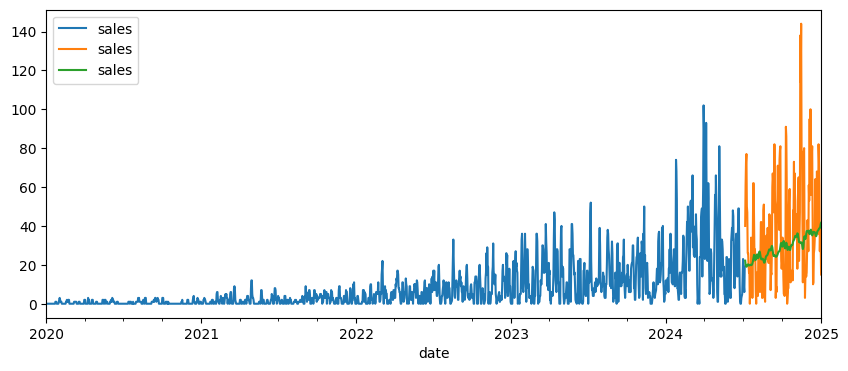

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[10].plot(ax=ax, label="Train")
y_test.loc[10].plot(ax=ax, label="Test")
y_pred_nbeats.loc[10].plot(ax=ax, label="N-BEATS")
fig.show()

## Zero-shot forecasting com N-BEATS

Zero-shot forecasting se refere ao fato de fazer previsão para uma série jamais
vista pelo modeo, sem utilizar a série para treinar ou ajustar parâmetros dele.

Aqui, para simular esse cenário, vamos criar uma nova série temporal combinando duas séries do conjunto de treino.

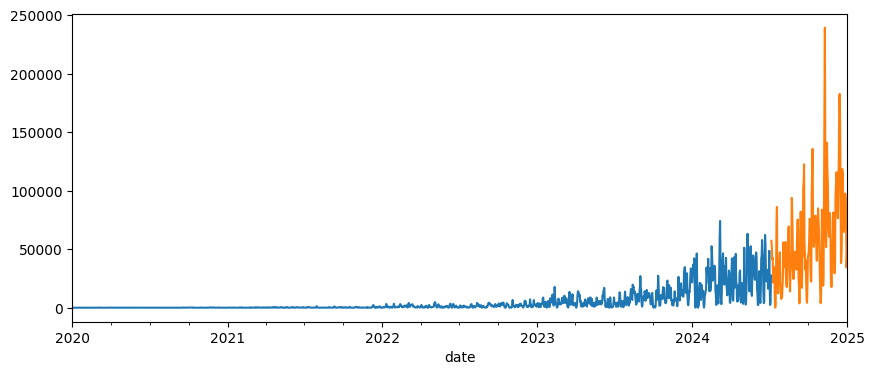

In [8]:
new_y_train = (y_train.loc[0]**2 + y_train.loc[20]).astype(float)
new_y_test = (y_test.loc[0]**2 + y_test.loc[20]).astype(float)

# Plotting the new series
fig, ax = plt.subplots(figsize=(10, 4))
new_y_train["sales"].plot.line(ax=ax, label="New Train")
new_y_test["sales"].plot.line(ax=ax, label="New Test")
fig.show()

Na interface atual do sktime, usamos o argumento `y` do método `predict` para passar a nova série temporal para o modelo:

In [9]:
y_pred_zeroshot = nbeats.predict(fh=fh, y=new_y_train)

/Users/felipeangelim/Workspace/python_brasil_2025/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


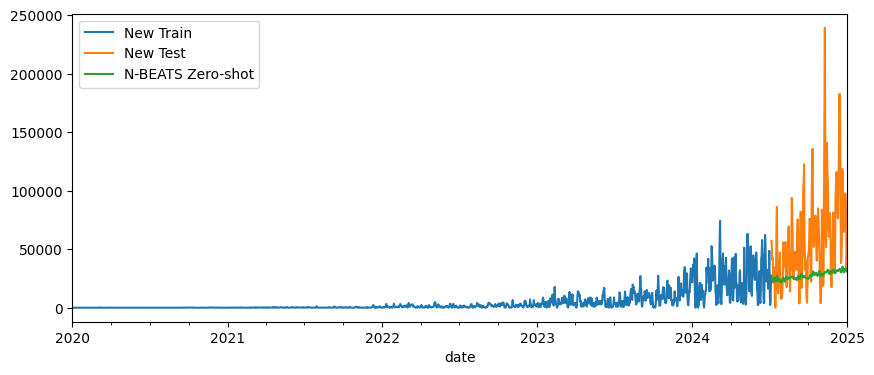

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
new_y_train["sales"].plot.line(ax=ax, label="New Train")
new_y_test["sales"].plot.line(ax=ax, label="New Test")
y_pred_zeroshot["sales"].plot.line(ax=ax, label="N-BEATS Zero-shot")
plt.legend()
plt.show()